In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout

import math
from datetime import date, timedelta, datetime

In [2]:
# Read training and test data
train_data = pd.read_csv('Google_Stock_Price_Train.csv')
test_data = pd.read_csv('Google_Stock_Price_Test.csv')
print(train_data.head())

train_close = train_data['Close'].values
test_close = test_data['Close'].values

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800


In [3]:
train_data['Close'] = train_data['Close'].str.replace(',', '').astype(float)

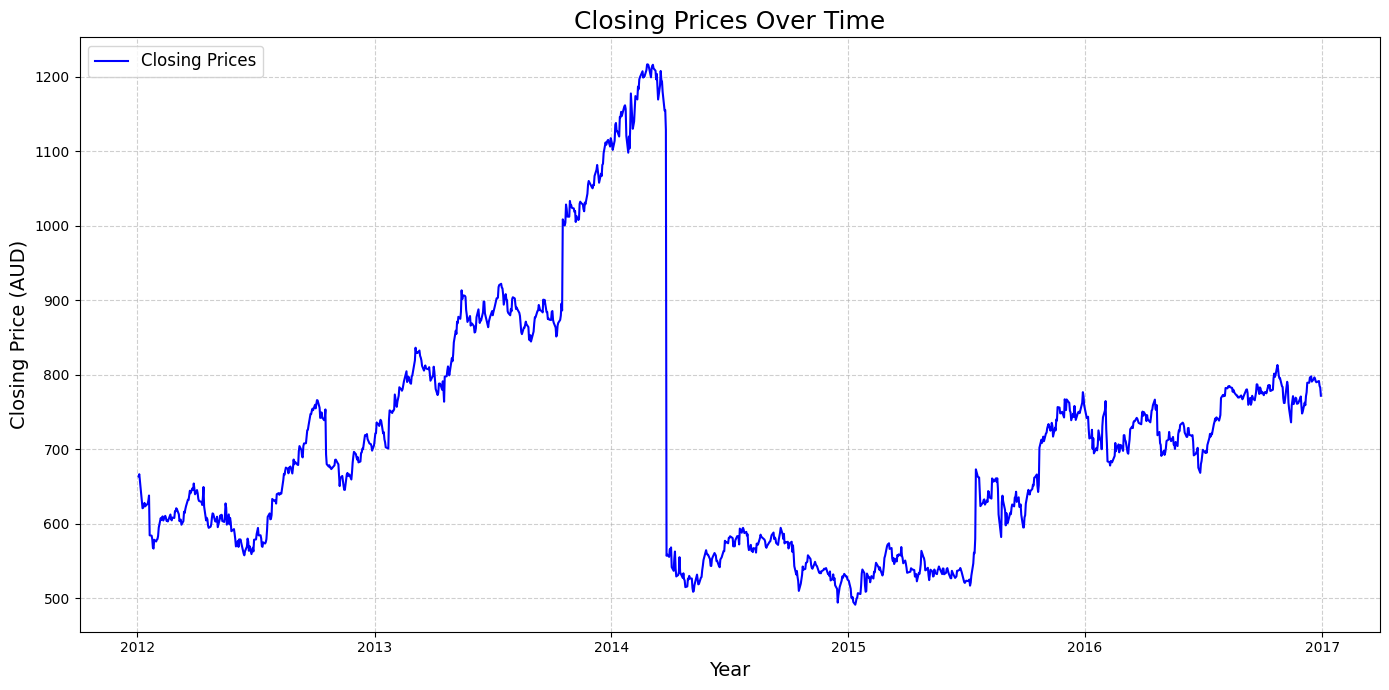

In [4]:
# Ensure data consistency
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data.set_index('Date', inplace=True)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Close'], color='blue', label='Closing Prices')
plt.title('Closing Prices Over Time', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Closing Price (AUD)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [12]:
if train_data['Close'].dtype == 'object':
    train_data['Close'] = train_data['Close'].str.replace(',', '').astype(float)

if test_data['Close'].dtype == 'object':
    test_data['Close'] = test_data['Close'].str.replace(',', '').astype(float)

# Convert the ‘Close’ columns of the training and test sets into numpy arrays
train_close = train_data['Close'].values.reshape(-1, 1)
test_close = test_data['Close'].values.reshape(-1, 1)

# Normalised data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_close)

# Create training samples (using 60 time steps to predict the next value)
x_train = []
y_train = []
for i in range(60, len(train_scaled)):
    x_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape data to fit the input format of LSTM, GRU and RNN models
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Prepare test data
total_data = np.concatenate((train_close, test_close), axis=0)
inputs = total_data[len(total_data) - len(test_close) - 60:]
inputs = scaler.transform(inputs)

x_test = []
for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [25]:
def build_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_gru_model():
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(GRU(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_lstm_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [26]:
# Training RNN models
rnn_model = build_rnn_model()
rnn_model.fit(x_train, y_train, epochs=50, batch_size=32)
rnn_predicted = rnn_model.predict(x_test)
rnn_predicted = scaler.inverse_transform(rnn_predicted)

# Training GRU models
gru_model = build_gru_model()
gru_model.fit(x_train, y_train, epochs=50, batch_size=32)
gru_predicted = gru_model.predict(x_test)
gru_predicted = scaler.inverse_transform(gru_predicted)

# Training LSTM models
lstm_model = build_lstm_model()
lstm_model.fit(x_train, y_train, epochs=50, batch_size=32)
lstm_predicted = lstm_model.predict(x_test)
lstm_predicted = scaler.inverse_transform(lstm_predicted)


2024-11-17 19:23:33.084135: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-17 19:23:33.084790: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-17 19:23:33.085194: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-17 19:23:33.085873: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-17 19:23:33.086648: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential mo

Epoch 1/50


2024-11-17 19:23:34.757797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


38/38 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - loss: 0.1178
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - loss: 0.0316
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - loss: 0.0204
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 199s 5s/step - loss: 0.0134
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - loss: 0.0122
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - loss: 0.0089
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - loss: 0.0072
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - loss: 0.0075
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 175s 5s/step - loss: 0.0067
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step - loss: 0.0053
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - loss: 0.0046
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - loss: 0.0044
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - loss: 0.0039
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - loss: 0.0041
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - loss: 0.0036
Epoch 16/50
38/

/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0472
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0039
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0025
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0039
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0029
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0027
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0026
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0026
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0023
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0035
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0022
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017
Epoch 16/50
38

/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0494
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0064
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0074
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0045
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0062
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0039
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0035
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0039
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0047
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0029
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0039
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0030
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0037
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0030
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0031
Epoch 16/50
38/

The root mean squared error for RNN is: 8.95220546710771.
The root mean squared error for GRU is: 8.858238579976799.
The root mean squared error for LSTM is: 12.781393687852049.


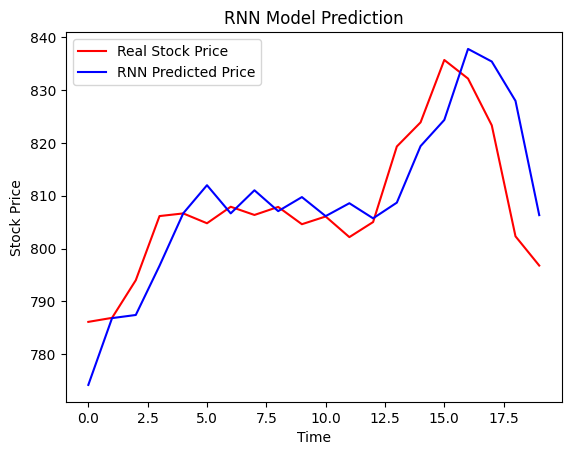

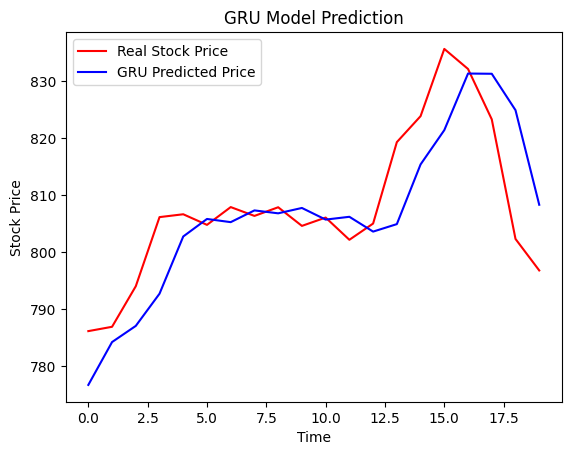

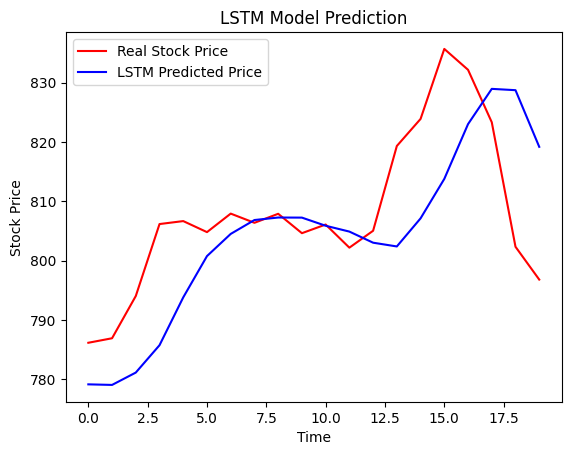

In [29]:
def return_rmse(test, predicted, model_name):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print(f"The RMSE for {model_name} is: {rmse}.")

# Calculate RMSE for each model
return_rmse(test_close, rnn_predicted, "RNN")
return_rmse(test_close, gru_predicted, "GRU")
return_rmse(test_close, lstm_predicted, "LSTM")

def plot_predictions(test, predicted, model_name):
    plt.plot(test, color="red", label="Real Stock Price")
    plt.plot(predicted, color="blue", label=f"{model_name} Predicted Price")
    plt.title(f"{model_name} Model Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()
    plt.style.use("fivethirtyeight")

plot_predictions(test_close, rnn_predicted, "RNN")
plot_predictions(test_close, gru_predicted, "GRU")
plot_predictions(test_close, lstm_predicted, "LSTM")

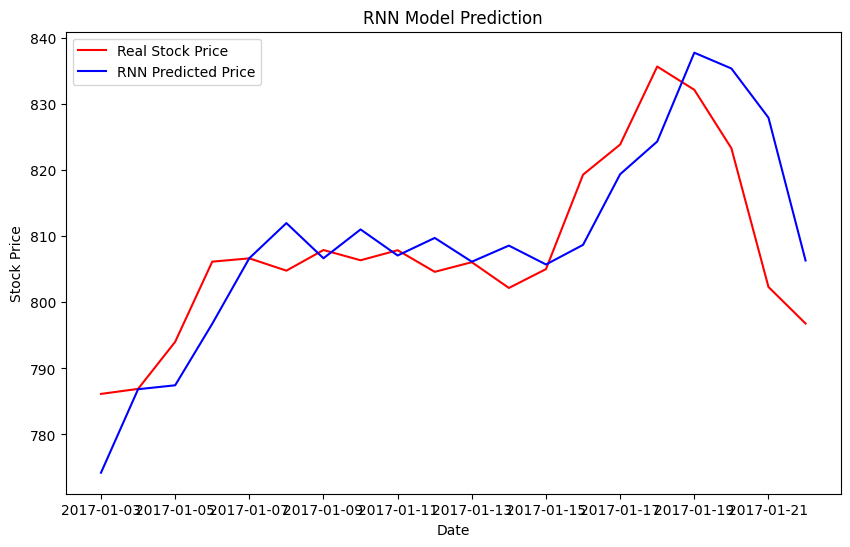

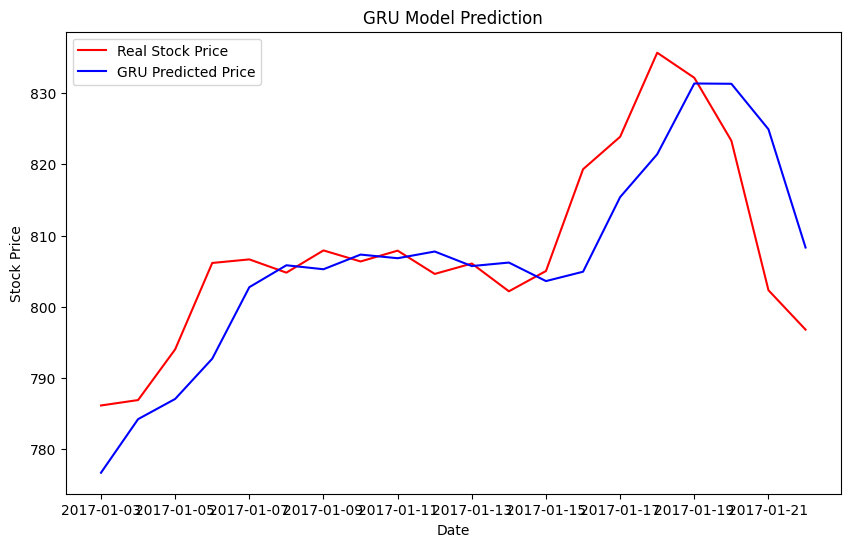

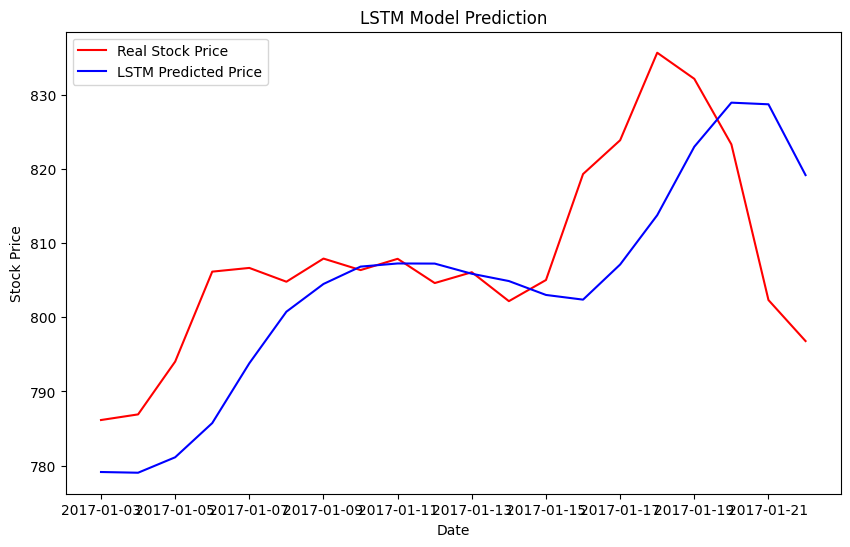

In [40]:

dates = pd.date_range(start='01/03/2017', periods=len(test_close))


def plot_predictions(test, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(dates, test, color="red", label="Real Stock Price")
    plt.plot(dates, predicted, color="blue", label=f"{model_name} Predicted Price")
    plt.title(f"{model_name} Model Prediction")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


plot_predictions(test_close, rnn_predicted, "RNN")
plot_predictions(test_close, gru_predicted, "GRU")
plot_predictions(test_close, lstm_predicted, "LSTM")


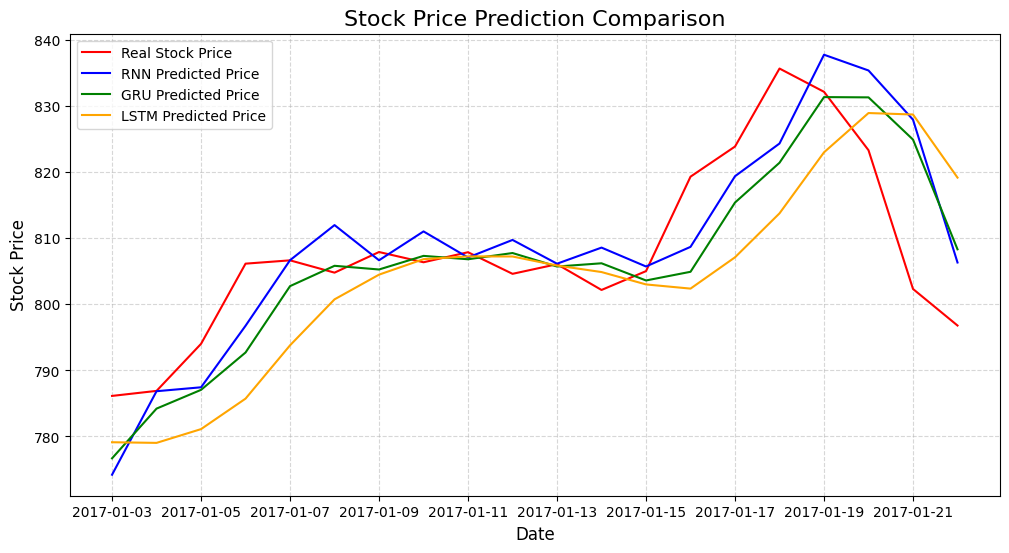

In [43]:
# Generating the date range for the x-axis
dates = pd.date_range(start='01/03/2017', periods=len(test_close))

# Plotting all models in one graph
plt.figure(figsize=(12, 6))

# Plotting the real stock price
plt.plot(dates, test_close, color="red", label="Real Stock Price")

# Plotting the predictions of each model
plt.plot(dates, rnn_predicted, color="blue", label="RNN Predicted Price")
plt.plot(dates, gru_predicted, color="green", label="GRU Predicted Price")
plt.plot(dates, lstm_predicted, color="orange", label="LSTM Predicted Price")

# Adding titles and labels
plt.title("Stock Price Prediction Comparison", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock Price", fontsize=12)
plt.legend()

# Displaying the grid and the plot
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()
